## Импорт библиотек

In [1]:
import torch
from model import *
from getloader import get_loader
import torchvision.transforms as transforms
from PIL import Image
from IPython import display
import pandas as pd
from checkmetric import *

## Функция подгрузки модели

In [2]:
def load_model_to_captioning(image_path="archive/images",
                             caption_path="archive/captions.txt",
                             checkpoint_path="my_checkpoint.pth.tar"):
    
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    
    test_loader, dataset = get_loader(
        root_folder=image_path,
        annotation_file=caption_path,
        transform=transform,
        num_workers=6,
    )
    
    device = "cuda"
    embedding_size = 256
    hidden_size = 256
    vocabulary_size = len(dataset.vocabulary)
    num_layers = 4
    model = CNNtoRNNTranslator(embedding_size, hidden_size, vocabulary_size, num_layers).to(device)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])
    
    return model, dataset.vocabulary, transform

## Функция создания подписи

In [3]:
def create_caption(image_path, model, vocabulary, transform, device="cuda", show_image=False):
    model.eval()
    image = transform(Image.open(image_path).convert("RGB")).unsqueeze(0)
    word_list = model.image_caption(image.to(device), vocabulary)
    word_list = [word for word in word_list if not (word in [*vocabulary.stoi][:4])]
    caption = ' '.join([str(elem) for elem in word_list])
    if show_image:
        display.display(Image.open(image_path))
    return caption

## Запуск функций выше

In [3]:
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

KeyboardInterrupt: 

In [19]:
model, vocab, transform = load_model_to_captioning(caption_path="archive/training_captions.txt",
                                                   checkpoint_path="my_checkpoint_epoc_60_nl_4_lr_0.0004.pth.tar")

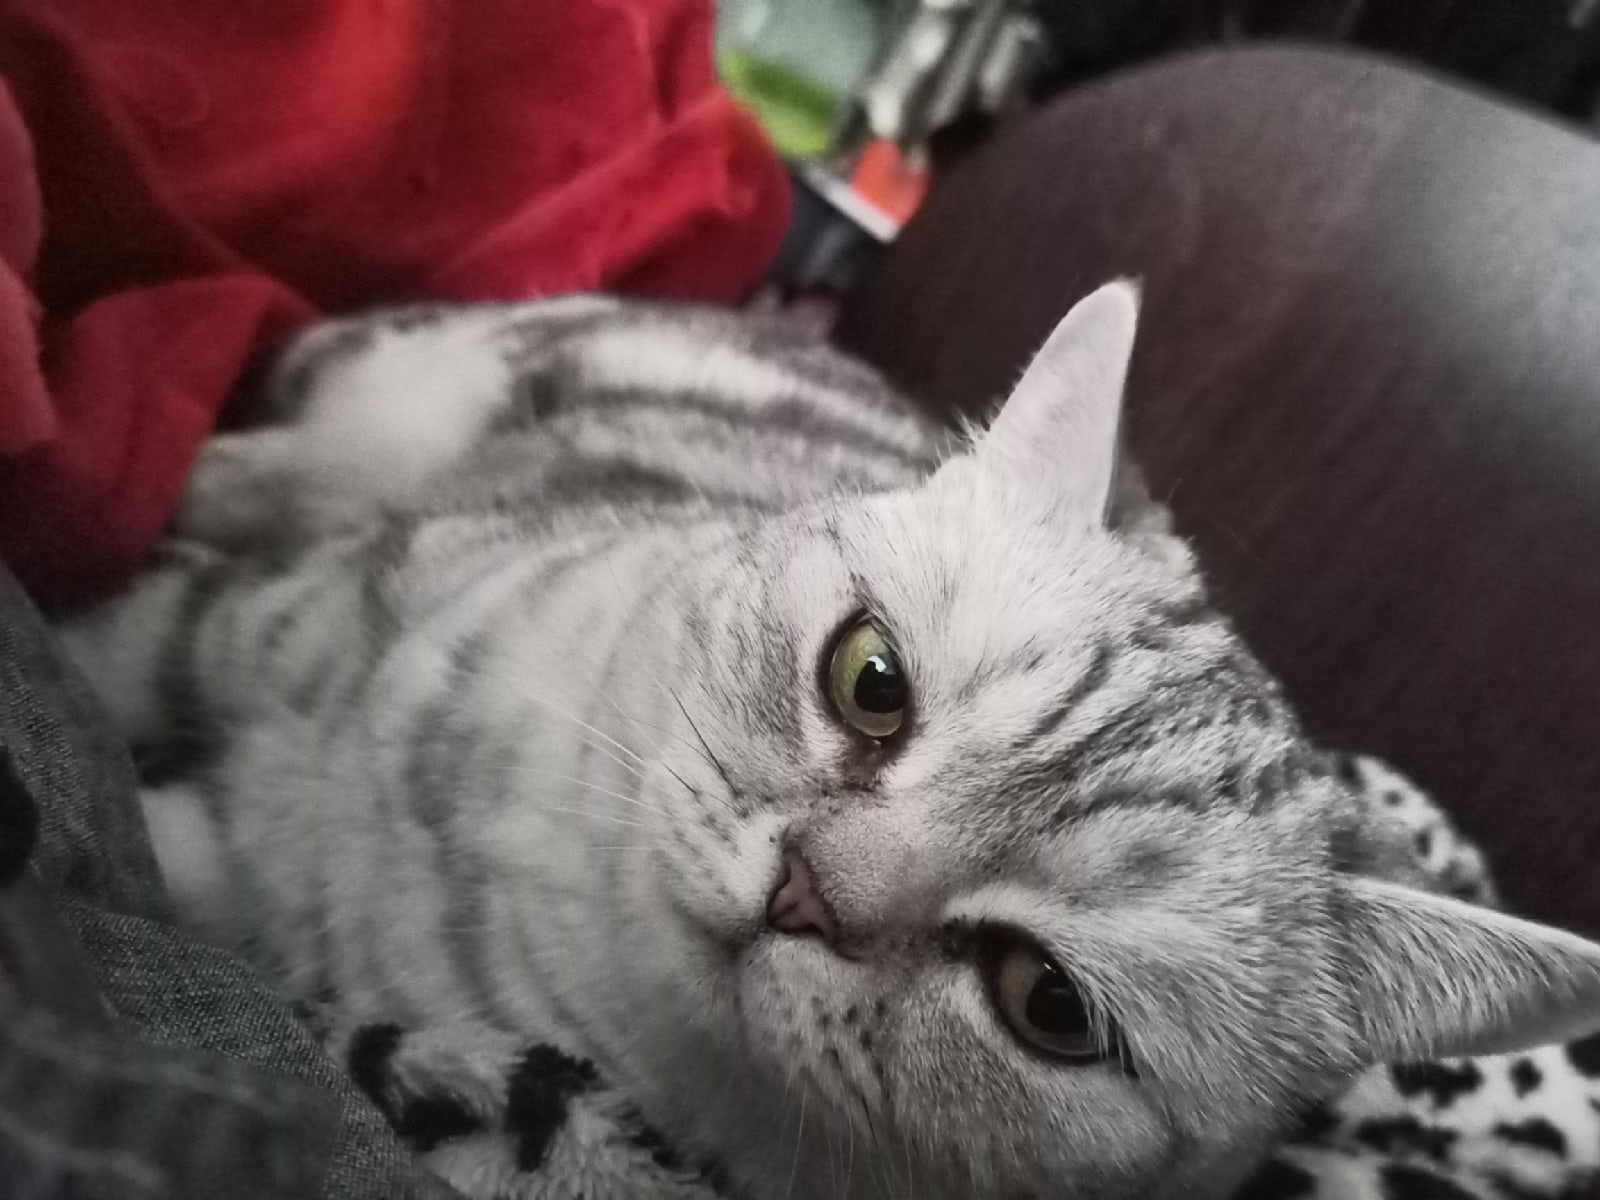

'a white dog is running on the grass .'

In [22]:
create_caption("test/images/11.png", model, vocab, transform, show_image=True)
# create_caption("test/images/10.jpg", show_image=True)

Определяются переменные, содержащие директории к тестовой выборке

In [5]:
train_image_path="archive/images"
train_caption_path="archive/captions.txt"

## Проверка качества модели

In [36]:
from sentence_transformers import SentenceTransformer
import numpy as np

### Демонстрация принципа работы косинусного коэффициента

In [37]:
def cosine_similarity(sentence_embeddings, ind_a, ind_b):
    s = sentence_embeddings
    return np.dot(s[ind_a], s[ind_b]) / (np.linalg.norm(s[ind_a]) * np.linalg.norm(s[ind_b]))

Sent_Trans_model = SentenceTransformer('bert-base-nli-mean-tokens')

s0 = "our president is a good leader he will not fail"
s1 = "our president is not a good leader he will fail"
s2 = "our president is a good leader"
s3 = "our president will succeed"

sentences = [s0, s1, s2, s3]

sentence_embeddings = Sent_Trans_model.encode(sentences)

s = sentence_embeddings

print(f"{s0} <--> {s1}: {cosine_similarity(sentence_embeddings, 0, 1)}")
print(f"{s0} <--> {s2}: {cosine_similarity(sentence_embeddings, 0, 2)}")
print(f"{s0} <--> {s3}: {cosine_similarity(sentence_embeddings, 0, 3)}")

our president is a good leader he will not fail <--> our president is not a good leader he will fail: 0.46340951323509216
our president is a good leader he will not fail <--> our president is a good leader: 0.8822923302650452
our president is a good leader he will not fail <--> our president will succeed: 0.7640182375907898


### Функция проверки качества модели с помощью тестовой выборки

In [38]:
def check_quality(images_path="archive/images", captions_path="archive/captions.txt"):
    df = pd.read_csv(captions_path)
    quality = 0
    
    for elem in df.iterrows():
        image_name = elem[1][1]
        ans_caption = elem[1][2]
        out_caption = create_caption(images_path + "/" + str(image_name), model, vocab, transform)
        
        sentences = [out_caption, ans_caption]
        sentence_embeddings = Sent_Trans_model.encode(sentences)
        quality += cosine_similarity(sentence_embeddings, 0, 1)
        
    print("average quality: ", quality / df.shape[0])

### Запуск проверки качества

In [39]:
check_quality(captions_path="archive/testing_captions.txt")

average quality:  0.45774423108350076


Таким образом, среднее значение метрики, определяющей качество модели при текущей конфигурации гиперпараметров и выборках данных, примерно равна ~0.486

In [6]:
from torch import nn
from torchviz import make_dot, make_dot_from_trace

In [ ]:
dict(model.named_parameters())

In [ ]:
def make_y():
    """
        Функция осуществляет процесс обучения модели машинного обучения.

    """

    # преобразования, которым подлежат изображения
    transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # определение объектов загрузчика данных с объектом датасета с учетом пути
    # к нужным файлам и заданными преобразованиями изображений
    train_loader, dataset = get_loader(
        root_folder="archive/images",
        annotation_file="archive/training_captions.txt",
        transform=transform,
        num_workers=6,
    )

    # обучение будет происходит с помощью технологии Cuda
    torch.backends.cudnn.benchmark = True
    print("cuda: ", torch.cuda.is_available())
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = False
    save_model = True

    # задача гиперпараметров
    embedding_size = 256
    hidden_size = 256
    vocabulary_size = len(dataset.vocabulary)
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 100

    # в процессе обучения будут сохраняться характеристики,
    # отображаемые с помощью tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0

    # инициализация модели, функции потерь и оптимизатора
    model = CNNtoRNNTranslator(embedding_size,
                               hidden_size,
                               vocabulary_size,
                               num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocabulary.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # включение режима обучения модели
    model.train()

    for epoch in range(num_epochs + 1):
        for idx, (imgs, captions) in enumerate(train_loader):
            imgs = imgs.to(device)
            captions = captions.to(device)
            outputs = model(imgs, captions[:-1])

            return outputs

In [15]:
make_dot(model(img, capt[:-1]), params=dict(model.named_parameters()))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [12]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz/bin/'

In [1]:
1

1